# Hierarchical policies

In this notebook, we compare heterogeneity-agnostic and heterogeneity-aware multi-level policies (multi-level fairness and a fairness+FIFO policy).

## Import statements

In [1]:
import sys
sys.path = ["../../.."] + sys.path
from job_table import JobTable
import utils
from policies.max_min_fairness_water_filling \
    import MaxMinFairnessWaterFillingPolicyWithPerf
from policies.max_min_fairness_water_filling \
    import MaxMinFairnessWaterFillingPolicy

In [2]:
from plotting_utils import *

In [3]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

## Create problem instance

In [4]:
def create_problem_instance(priority_reweighting_policy, num_jobs,
                            iteration, num_iterations,
                            random_throughputs=True):
    oracle_throughputs = utils.read_all_throughputs_json_v2(
        "../../../simulation_throughputs.json")
    import random
    random.seed(0)
    num_entities = 3
    priority_reweighting_policies = {}
    entity_weights = {}
    unflattened_priority_weights = {}
    entity_to_job_mapping = {}
    for i in range(num_entities):
        entity_id = 'entity%d' % i
        priority_reweighting_policies[entity_id] = priority_reweighting_policy
        entity_to_job_mapping[entity_id] = []
        entity_weights[entity_id] = (i + 1)

    worker_types = ['k80', 'p100', 'v100']
    cluster_spec = {worker_type: 3 for worker_type in worker_types}
    unflattened_throughputs = {}
    scale_factors = {}
    num_workers_requested = 0
    for i in range(int(iteration * (num_jobs // num_iterations))):
        if random_throughputs:
            throughputs = [random.random() for j in range(len(worker_types))]
            throughputs.sort()
            unflattened_throughputs[i] = {
                worker_types[j]: throughputs[j] for j in range(len(worker_types))}
        else:
            job_type = random.choice(JobTable).model
            unflattened_throughputs[i] = {
                worker_type: oracle_throughputs[worker_type][(job_type, 1)]['null']
                for worker_type in worker_types}
        scale_factors[i] = 1
        num_workers_requested += scale_factors[i]
        entity_id = 'entity%d' % (i // (num_jobs // 3))
        priority_weight = (i % 2) + 1
        if priority_reweighting_policies[entity_id] == 'fifo':
            priority_weight = 1.0
        unflattened_priority_weights[i] = priority_weight
        entity_to_job_mapping[entity_id].append(i)
        
    return (unflattened_throughputs, scale_factors, unflattened_priority_weights,
            cluster_spec, entity_weights, entity_to_job_mapping), priority_reweighting_policies

## Plotting and simulation functions

In [5]:
def plot_fractional_effective_throughputs_as_timeseries(
    all_effective_throughputs, num_iterations,
    output_filename=None):
    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    accumulated_y = np.zeros(num_iterations)
    prev_to_plot_y = None
    colors = ['royalblue', 'deepskyblue', 'powderblue']
    for job_id in all_effective_throughputs:
        # Plot fractional effective throughput for each job
        # in a stacked manner.
        x = range(1, num_iterations+1)
        to_plot_y = np.array(all_effective_throughputs[job_id]) + \
            accumulated_y
        ax.plot(x, to_plot_y,
                color='k')
        # Color each entity.
        if (job_id+1) % 6 == 0:
            if prev_to_plot_y is None:
                prev_to_plot_y = np.zeros(num_iterations)
            ax.fill_between(x, prev_to_plot_y, to_plot_y,
                            label="Entity %d" % (job_id // 6),
                            color=colors[job_id // 6])
            prev_to_plot_y = to_plot_y
        accumulated_y += np.array(all_effective_throughputs[job_id])
        
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fraction of total\neffective throughput")
    ax.set_xlim([1, None])
    ax.set_ylim([0, None])
    sns.despine()
    leg = plt.figlegend(frameon=False, ncol=3, loc='upper center')
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.1
    bb.y1 += 0.1
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()
    
def plot_fractional_effective_throughputs_as_bar_chart(
    all_effective_throughputs, num_iterations):
    plt.figure(figsize=(8, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    old_to_plot_y = np.zeros(num_iterations)
    old_entity_id = 0
    for job_id in all_effective_throughputs:
        x = range(1, num_iterations+1)
        entity_id = job_id // 6
        if entity_id != old_entity_id:
            old_to_plot_y = np.zeros(num_iterations)
            old_entity_id = entity_id
        x = [x_elem * 2 for x_elem in x]
        x = [x_elem + (entity_id * 0.5) for x_elem in x]
        to_plot_y = np.array(all_effective_throughputs[job_id])
        if job_id % 6 == 0:
            ax.bar(x, to_plot_y, bottom=old_to_plot_y, width=0.4,
                   color=current_palette[entity_id], edgecolor='k',
                   label="Entity %d" % entity_id)
        else:
            ax.bar(x, to_plot_y, bottom=old_to_plot_y, width=0.4,
                   color=current_palette[entity_id], edgecolor='k')
        old_to_plot_y += to_plot_y
        
    ax.set_xticks([(x_elem*2 + 0.5) for x_elem in range(1, num_iterations+1)])
    ax.set_xticklabels(range(1, num_iterations+1))
        
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Fraction of total\neffective throughput")
    ax.set_ylim([0, None])
    sns.despine()
    plt.figlegend(frameon=False)
    plt.show()
    
def plot_total_effective_throughput(
    total_effective_throughputs, total_effective_throughputs_static,
    num_iterations, output_filename=None):
    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    x = range(1, num_iterations+1)
    ax.plot(x, total_effective_throughputs_static, label='Multi-level fairness')
    ax.plot(x, total_effective_throughputs, label='Gavel')
        
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Total effective\nthroughput")
    ax.set_xlim([0, None])
    ax.set_ylim([0, None])
    sns.despine()
    leg = plt.figlegend(frameon=False, ncol=1, loc='best')
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 -= 0.7
    bb.y1 -= 0.7
    bb.x0 -= 0.15
    bb.x1 -= 0.15
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        output_filename = output_filename.replace(".pdf", "_total_throughput.pdf")
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

## Simulation functions (jobs added one-by-one every 4 timeunits, entities round robined)

In [6]:
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull

def test_water_filling_multilevel(priority_reweighting_policy, random_throughputs,
                                  output_filename=None):
    all_effective_throughputs = {}
    all_effective_throughputs_without_perf = {}
    total_effective_throughputs = []
    total_effective_throughputs_without_perf = []
    num_iterations = 72
    num_jobs_added = 1
    num_jobs = 18
    for i in range(1, num_iterations+1):
        problem_instance, priority_reweighting_policies = \
            create_problem_instance(priority_reweighting_policy,
                                    num_jobs, num_jobs_added, num_jobs,
                                    random_throughputs=random_throughputs)
        policy = MaxMinFairnessWaterFillingPolicyWithPerf(
            priority_reweighting_policies=priority_reweighting_policies)
        policy_without_perf = MaxMinFairnessWaterFillingPolicy(
            priority_reweighting_policies=priority_reweighting_policies)
        with open(devnull, 'w') as fnull:
            with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
                effective_throughputs = policy.get_allocation(
                    *problem_instance, return_effective_throughputs=True)
                effective_throughputs_without_perf = policy_without_perf.get_allocation(
                    *problem_instance, return_effective_throughputs=True)
        (_, _, priority_weights, _, entity_weights, entity_to_job_mapping) = problem_instance
        
        for job_id in range(num_jobs):
            if job_id not in all_effective_throughputs:
                all_effective_throughputs[job_id] = []
                all_effective_throughputs_without_perf[job_id] = []
            all_effective_throughputs[job_id].append(0.0)
            all_effective_throughputs_without_perf[job_id].append(0.0)
        total_effective_throughput = 0.0
        total_effective_throughput_without_perf = 0.0
        for job_id in range(len(effective_throughputs)):
            total_effective_throughput += effective_throughputs[job_id]
            total_effective_throughput_without_perf += \
                effective_throughputs_without_perf[job_id]
        print("Perf:", effective_throughputs)
        print("Perf-agnostic:", effective_throughputs_without_perf)
        total_effective_throughputs.append(total_effective_throughput)
        total_effective_throughputs_without_perf.append(
            total_effective_throughput_without_perf)
        for job_id in range(len(effective_throughputs)):
            all_effective_throughputs[job_id][-1] = (
                effective_throughputs[job_id] / total_effective_throughput)
            all_effective_throughputs_without_perf[job_id][-1] = (
                effective_throughputs_without_perf[job_id] /
                total_effective_throughput_without_perf)
        if i % 4 == 0:
            num_jobs_added += 1

    plot_fractional_effective_throughputs_as_timeseries(
        all_effective_throughputs, num_iterations,
        output_filename=output_filename)
    plot_fractional_effective_throughputs_as_timeseries(
        all_effective_throughputs_without_perf, num_iterations)
    plot_fractional_effective_throughputs_as_bar_chart(
        all_effective_throughputs, num_iterations)
    plot_fractional_effective_throughputs_as_bar_chart(
        all_effective_throughputs_without_perf, num_iterations)
    plot_total_effective_throughput(
        total_effective_throughputs,
        total_effective_throughputs_without_perf,
        num_iterations, output_filename=output_filename)

## Plot per-job and total effective throughputs vs. timestep

Perf: [1.252]
Perf-agnostic: [1.]
Perf: [1.252]
Perf-agnostic: [1.]
Perf: [1.252]
Perf-agnostic: [1.]
Perf: [1.252]
Perf-agnostic: [1.]
Perf: [1.252 1.305]
Perf-agnostic: [1. 1.]
Perf: [1.252 1.305]
Perf-agnostic: [1. 1.]
Perf: [1.252 1.305]
Perf-agnostic: [1. 1.]
Perf: [1.252 1.305]
Perf-agnostic: [1. 1.]
Perf: [1.252 1.305 1.504]
Perf-agnostic: [1. 1. 1.]
Perf: [1.252 1.305 1.504]
Perf-agnostic: [1. 1. 1.]
Perf: [1.252 1.305 1.504]
Perf-agnostic: [1. 1. 1.]
Perf: [1.252 1.305 1.504]
Perf-agnostic: [1. 1. 1.]
Perf: [1.192 1.305 1.192 1.365]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.192 1.305 1.192 1.365]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.192 1.305 1.192 1.365]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.192 1.305 1.192 1.365]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.171 1.305 1.171 1.365 1.171]
Perf-agnostic: [0.906 1.    0.906 1.    0.906]
Perf: [1.171 1.305 1.171 1.365 1.171]
Perf-agnostic: [0.906 1.    0.906 1.    0.906]
Perf: [1.171 1.305 1.171 1.365 1.171]
Perf-agnostic: [0.906 1.    0.90

Perf: [0.202 0.404 0.202 0.404 0.202 0.404 0.404 0.808 0.404 0.808 0.404 0.808
 0.78  1.559 0.78  1.559 0.78 ]
Perf-agnostic: [0.167 0.333 0.167 0.333 0.167 0.333 0.333 0.667 0.333 0.667 0.333 0.667
 0.833 1.    0.833 1.    0.833]
Perf: [0.202 0.404 0.202 0.404 0.202 0.404 0.404 0.808 0.404 0.808 0.404 0.808
 0.78  1.559 0.78  1.559 0.78 ]
Perf-agnostic: [0.167 0.333 0.167 0.333 0.167 0.333 0.333 0.667 0.333 0.667 0.333 0.667
 0.833 1.    0.833 1.    0.833]
Perf: [0.201 0.402 0.201 0.402 0.201 0.402 0.402 0.805 0.402 0.805 0.402 0.805
 0.604 1.207 0.604 1.207 0.604 1.207]
Perf-agnostic: [0.167 0.333 0.167 0.333 0.167 0.333 0.333 0.667 0.333 0.667 0.333 0.667
 0.5   1.    0.5   1.    0.5   1.   ]
Perf: [0.201 0.402 0.201 0.402 0.201 0.402 0.402 0.805 0.402 0.805 0.402 0.805
 0.604 1.207 0.604 1.207 0.604 1.207]
Perf-agnostic: [0.167 0.333 0.167 0.333 0.167 0.333 0.333 0.667 0.333 0.667 0.333 0.667
 0.5   1.    0.5   1.    0.5   1.   ]
Perf: [0.201 0.402 0.201 0.402 0.201 0.402 0.402 0.8

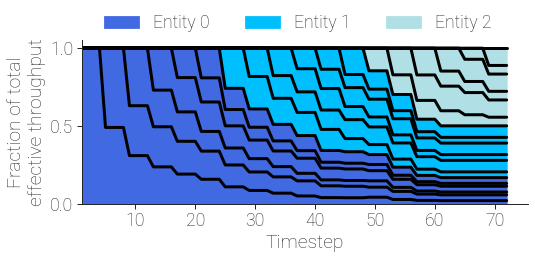

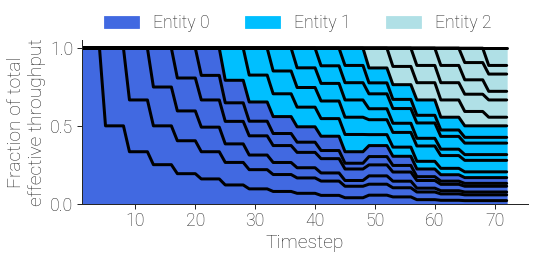

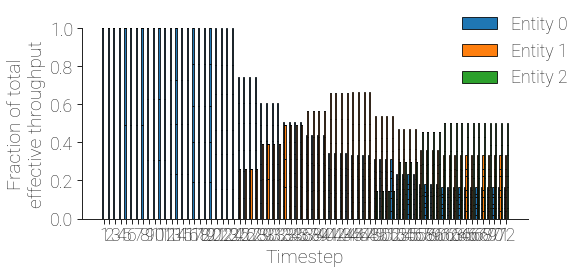

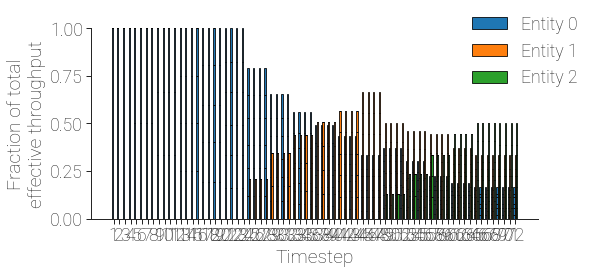

/Users/deepakn94/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


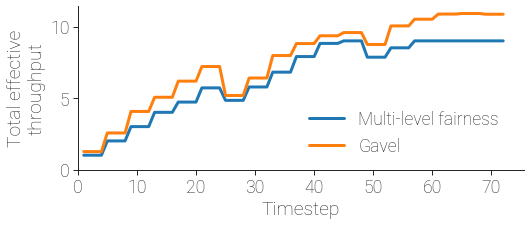

In [7]:
test_water_filling_multilevel('fairness', random_throughputs=True)

In [8]:
test_water_filling_multilevel('fairness', random_throughputs=False,
                              output_filename="hierarchical/multilevel_fairness.pdf")

Perf: [1.72]
Perf-agnostic: [1.]
Perf: [1.72]
Perf-agnostic: [1.]
Perf: [1.72]
Perf-agnostic: [1.]
Perf: [1.72]
Perf-agnostic: [1.]
Perf: [1.72  1.321]
Perf-agnostic: [1. 1.]
Perf: [1.72  1.321]
Perf-agnostic: [1. 1.]
Perf: [1.72  1.321]
Perf-agnostic: [1. 1.]
Perf: [1.72  1.321]
Perf-agnostic: [1. 1.]
Perf: [1.72  1.321 1.349]
Perf-agnostic: [1. 1. 1.]
Perf: [1.72  1.321 1.349]
Perf-agnostic: [1. 1. 1.]
Perf: [1.72  1.321 1.349]
Perf-agnostic: [1. 1. 1.]
Perf: [1.72  1.321 1.349]
Perf-agnostic: [1. 1. 1.]
Perf: [1.72  1.321 1.349 1.473]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.72  1.321 1.349 1.473]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.72  1.321 1.349 1.473]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.72  1.321 1.349 1.473]
Perf-agnostic: [1. 1. 1. 1.]
Perf: [1.365 1.321 1.317 1.473 1.362]
Perf-agnostic: [0.906 1.    0.906 1.    0.906]
Perf: [1.365 1.321 1.317 1.473 1.362]
Perf-agnostic: [0.906 1.    0.906 1.    0.906]
Perf: [1.365 1.321 1.317 1.473 1.362]
Perf-agnostic: [0.906 1.    0.906 1.

KeyboardInterrupt: 

In [ ]:
test_water_filling_multilevel('fifo', random_throughputs=True)

In [ ]:
test_water_filling_multilevel('fifo', random_throughputs=False,
                              output_filename="hierarchical/fairness+fifo.pdf")